In [8]:
#Uncomment the following lines to download the dogs and cats dataset from the Google API if you don't have it
#!wget --no-check-certificate \
    #https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    #-O /tmp/cats_and_dogs_filtered.zip

In [9]:
import os
import joblib
import zipfile
from shutil import move
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

import warnings
warnings.filterwarnings('ignore')

In [10]:
#We define the .zip and unzip paths
local_zip = '/Users/nfanlo/dev/technical-test/part1/data/cats_and_dogs_filtered.zip'
unzip_dir = '/Users/nfanlo/dev/technical-test/part1/data/data-unzip'

#Create directories for train, validation and test
train_dir = os.path.join(unzip_dir, 'train')
validation_dir = os.path.join(unzip_dir, 'validation')
test_dir = os.path.join(unzip_dir, 'test')

for category in ['train', 'validation', 'test']:
    for subcategory in ['cats', 'dogs']:
        os.makedirs(os.path.join(unzip_dir, category, subcategory), exist_ok=True)
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

#Move the files to their respective folders
original_train_dir = os.path.join(unzip_dir, 'cats_and_dogs_filtered', 'train')
original_validation_dir = os.path.join(unzip_dir, 'cats_and_dogs_filtered', 'validation')

for category in ['cats', 'dogs']:
    original_category_dir = os.path.join(original_train_dir, category)
    new_train_category_dir = os.path.join(train_dir, category)
    for fname in os.listdir(original_category_dir):
        move(os.path.join(original_category_dir, fname), os.path.join(new_train_category_dir, fname))

    original_category_dir = os.path.join(original_validation_dir, category)
    new_validation_category_dir = os.path.join(validation_dir, category)
    for fname in os.listdir(original_category_dir):
        move(os.path.join(original_category_dir, fname), os.path.join(new_validation_category_dir, fname))

#Divide the validation directory into validation and test (0.5)
def split_data(source_dir, dest_dir, split_ratio=0.5):
    filenames = os.listdir(source_dir)
    if len(filenames) == 0:
        raise ValueError(f'El directorio {source_dir} está vacío.')
    _, test_fnames = train_test_split(filenames, test_size=split_ratio, random_state=42)
    for fname in test_fnames:
        move(os.path.join(source_dir, fname), os.path.join(dest_dir, fname))

for category in ['cats', 'dogs']:
    split_data(os.path.join(validation_dir, category), os.path.join(test_dir, category))

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

def print_filenames_and_counts(dir_path, label):
    filenames = os.listdir(dir_path)
    filenames.sort()
    print(f'Total {label} images: {len(filenames)}')

print_filenames_and_counts(train_cats_dir, 'training cat')
print_filenames_and_counts(train_dogs_dir, 'training dog')
print_filenames_and_counts(validation_cats_dir, 'validation cat')
print_filenames_and_counts(validation_dogs_dir, 'validation dog')
print_filenames_and_counts(test_cats_dir, 'test cat')
print_filenames_and_counts(test_dogs_dir, 'test dog')

Total training cat images: 1000
Total training dog images: 1000
Total validation cat images: 250
Total validation dog images: 250
Total test cat images: 250
Total test dog images: 250


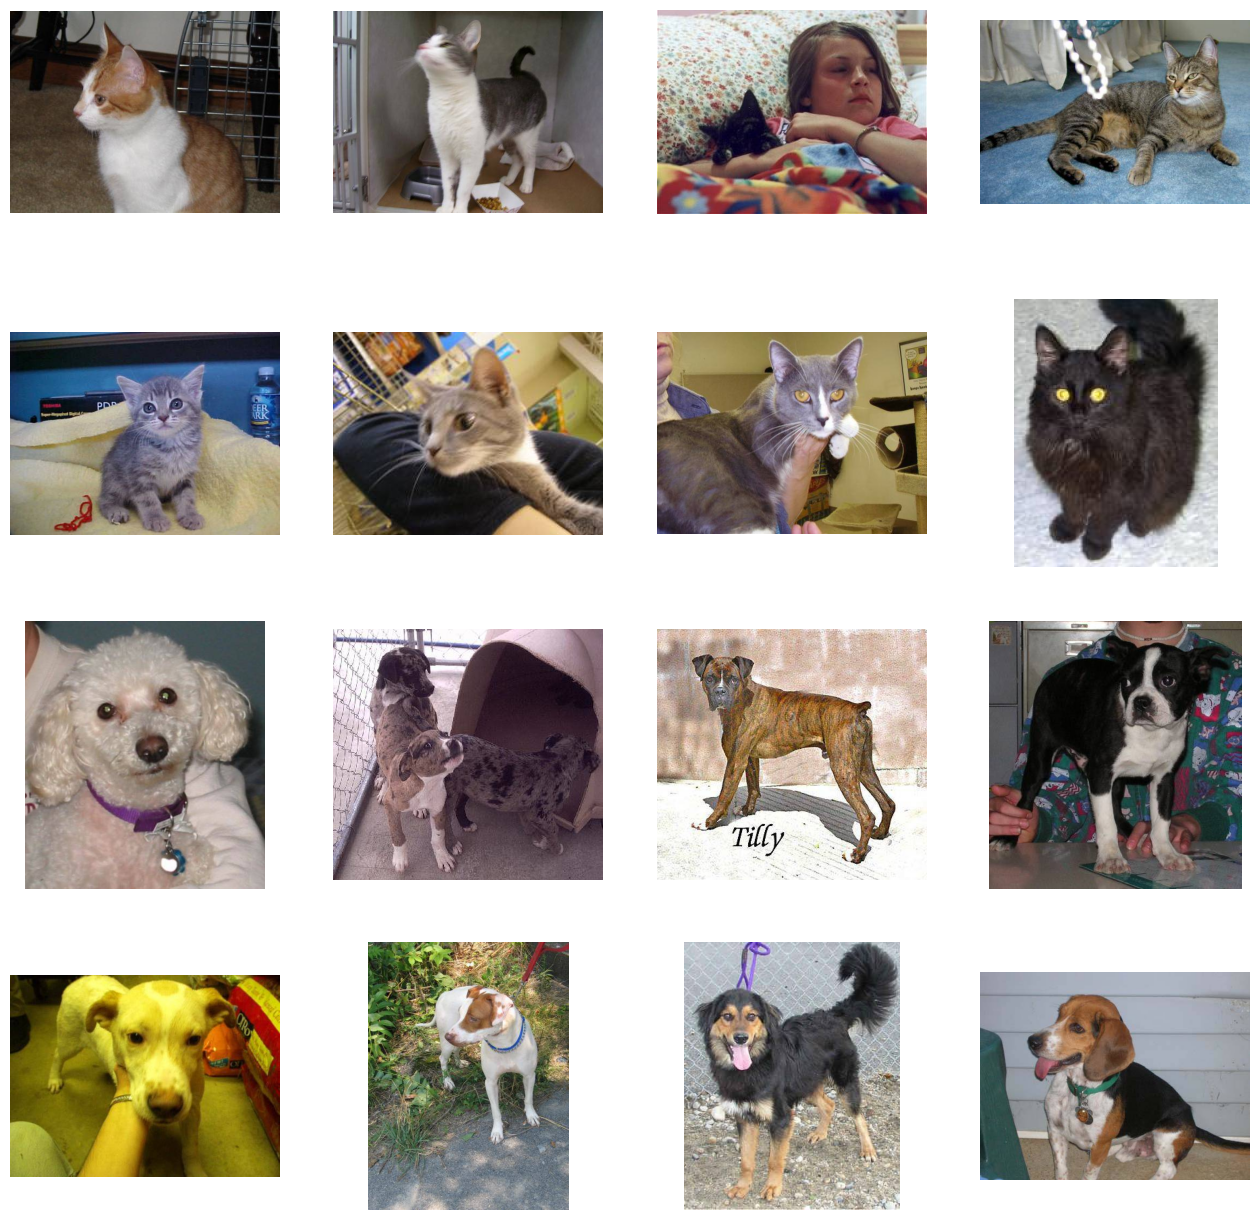

--------------------------------------------------------------------------------
Shape of one image: (375, 499, 3)


In [11]:
#Display a set of images of the train set

nrows, ncols = 4, 4
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index = 0
pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) for fname in os.listdir(train_dogs_dir)[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix + next_dog_pix):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()
print('-'*80)
print('Shape of one image:', mpimg.imread(next_cat_pix[0]).shape)


In [12]:
#A data augmentation is going to be performed on the train data set, we are going to perform a rescaling of the images (150x150) 
#for all image sets. Since the model will never see exactly the same image twice we will also avoid overfitting and improve the 
#generalization capabilities of the model during training process.

#Create the directory in the project to store the models
models_dir = '/Users/nfanlo/dev/technical-test/part1/models'
os.makedirs(models_dir, exist_ok=True)

#ImageDataGenerator for the training process with transformations in the images and rescaling
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

#ImageDataGenerator for validation and test with rescaling
datagen = ImageDataGenerator(rescale=1./255)

print('Images found by the generator:\n')
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    shuffle=True)

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    shuffle=False)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    shuffle=False)

Images found by the generator:

Found 2000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


--------------------------------------------------------------------------------
Best parameters for LogisticRegression: {'classifier__C': 10}
Validation accuracy for LogisticRegression: 0.546
Classification report:

              precision    recall  f1-score   support

         0.0       0.54      0.56      0.55       250
         1.0       0.55      0.53      0.54       250

    accuracy                           0.55       500
   macro avg       0.55      0.55      0.55       500
weighted avg       0.55      0.55      0.55       500

--------------------------------------------------------------------------------
Best parameters for KNeighbors: {'classifier__n_neighbors': 5}
Validation accuracy for KNeighbors: 0.55
Classification report:

              precision    recall  f1-score   support

         0.0       0.54      0.73      0.62       250
         1.0       0.58      0.37      0.45       250

    accuracy                           0.55       500
   macro avg       0.56      

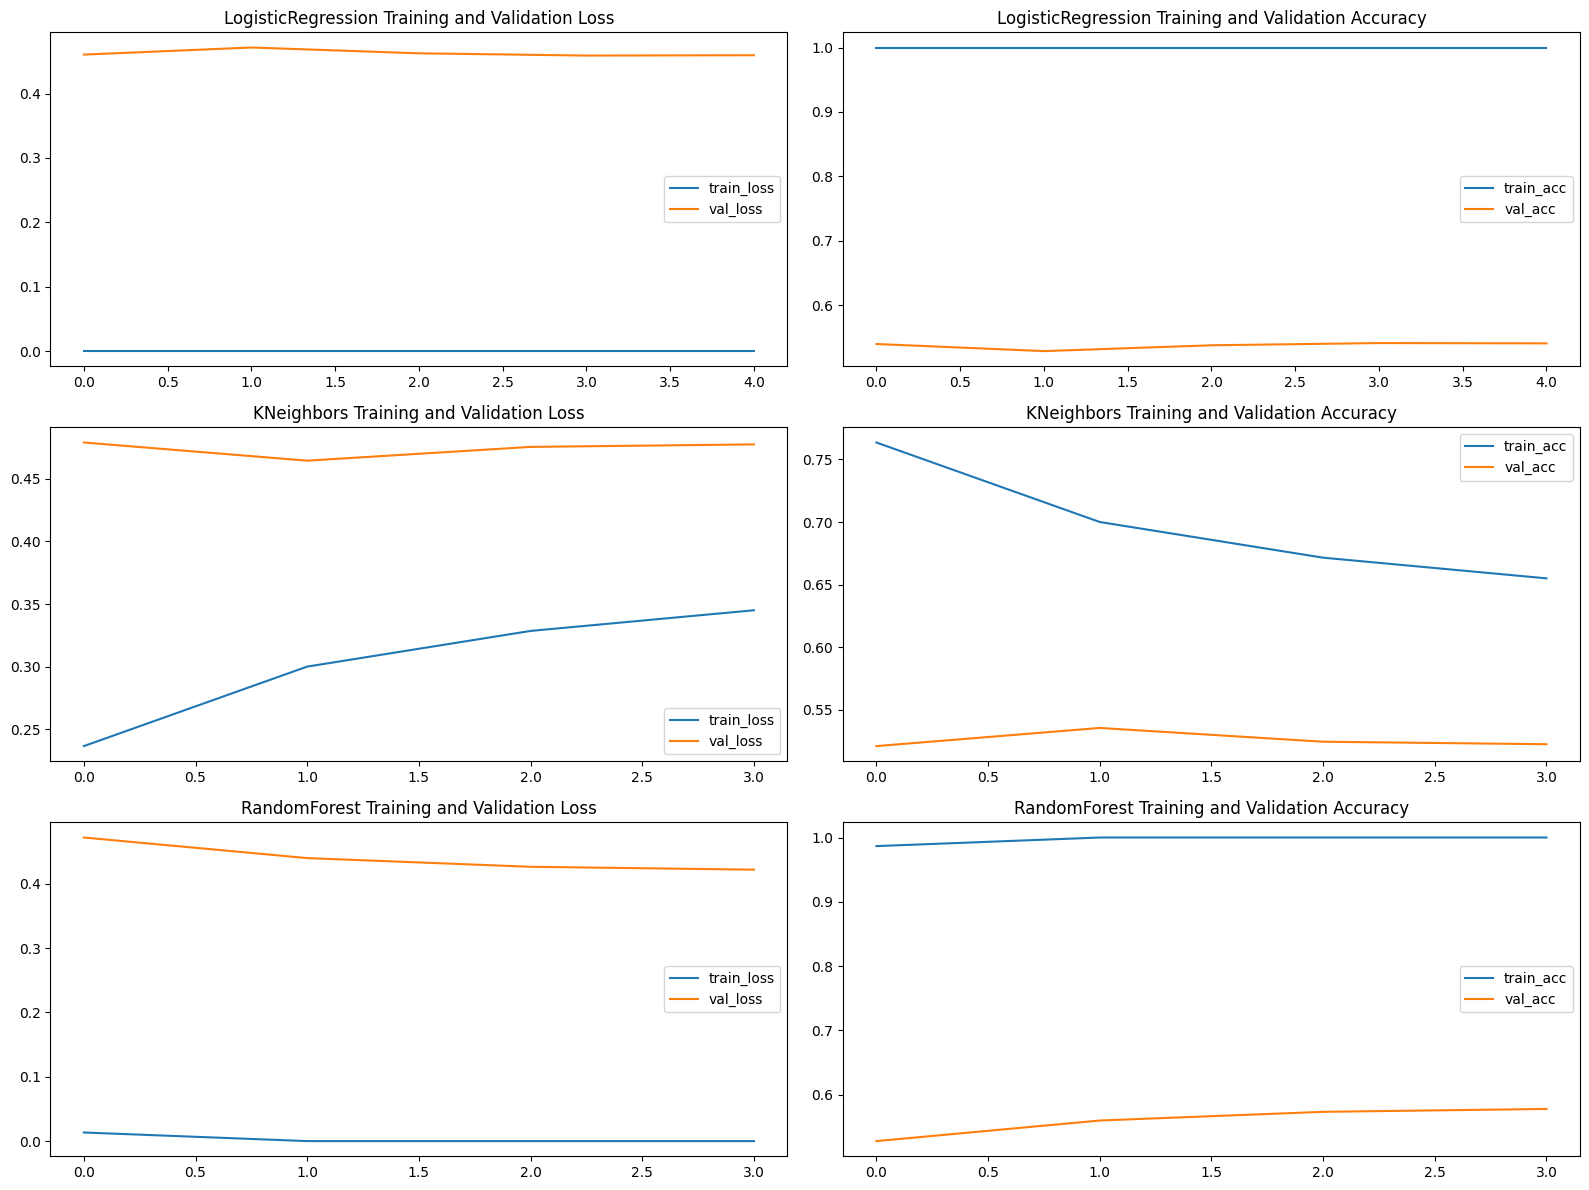

--------------------------------------------------------------------------------
BEST MODEL TEST: 

Test accuracy for RandomForest: 0.606
Classification report:

              precision    recall  f1-score   support

         0.0       0.59      0.70      0.64       250
         1.0       0.63      0.51      0.56       250

    accuracy                           0.61       500
   macro avg       0.61      0.61      0.60       500
weighted avg       0.61      0.61      0.60       500



In [13]:
def load_data_from_generator(generator):
    X, y = [], []
    for images, labels in generator:
        for img, label in zip(images, labels):
            X.append(img.flatten())
            y.append(label)
        if len(X) >= generator.samples:
            break
    return np.array(X), np.array(y)

X_train, y_train = load_data_from_generator(train_generator)
X_val, y_val = load_data_from_generator(validation_generator)
X_test, y_test = load_data_from_generator(test_generator)

#Classifiers to test
models = {'LogisticRegression': LogisticRegression(max_iter=1000),
    'KNeighbors': KNeighborsClassifier(),
    'RandomForest': RandomForestClassifier()}

#Hyperparámetres for the classifiers
param_grids = {'LogisticRegression': {'classifier__C': [0.01, 0.1, 1, 10, 100]},
    'KNeighbors': {'classifier__n_neighbors': [3, 5, 7, 9]},
    'RandomForest': {'classifier__n_estimators': [10, 50, 100, 200]}}

best_estimators = {}
best_scores = {}
history = {}

print('-'*80)
for name, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)])
    grid_search = GridSearchCV(pipeline, param_grid=param_grids[name], cv=5, scoring='accuracy', return_train_score=True)
    grid_search.fit(X_train, y_train)
    best_estimators[name] = grid_search.best_estimator_
    best_scores[name] = grid_search.best_score_
    y_pred = grid_search.predict(X_val)
    print(f'Best parameters for {name}: {grid_search.best_params_}')
    print(f'Validation accuracy for {name}: {accuracy_score(y_val, y_pred)}')
    print('Classification report:\n')
    print(classification_report(y_val, y_pred))
    print('-'*80)

    joblib.dump(grid_search.best_estimator_, os.path.join(models_dir, f'best_{name}.pkl'))
    
    history[name] = {
        'train_loss': 1 - grid_search.cv_results_['mean_train_score'],
        'val_loss': 1 - grid_search.cv_results_['mean_test_score'],
        'train_acc': grid_search.cv_results_['mean_train_score'],
        'val_acc': grid_search.cv_results_['mean_test_score']}

num_models = len(history)
fig, axes = plt.subplots(num_models, 2, figsize=(16, 4 * num_models))

for i, (name, hist) in enumerate(history.items()):
    epochs = range(len(hist['train_loss']))
    
    axes[i, 0].plot(epochs, hist['train_loss'], label='train_loss')
    axes[i, 0].plot(epochs, hist['val_loss'], label='val_loss')
    axes[i, 0].set_title(f'{name} Training and Validation Loss')
    axes[i, 0].legend()

    axes[i, 1].plot(epochs, hist['train_acc'], label='train_acc')
    axes[i, 1].plot(epochs, hist['val_acc'], label='val_acc')
    axes[i, 1].set_title(f'{name} Training and Validation Accuracy')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()
print('-'*80)

best_model_name = max(best_scores, key=best_scores.get)
best_model = best_estimators[best_model_name]

y_test_pred = best_model.predict(X_test)
print('BEST MODEL TEST: \n')
print(f'Test accuracy for {best_model_name}: {accuracy_score(y_test, y_test_pred)}')
print('Classification report:\n')
print(classification_report(y_test, y_test_pred))

In [14]:
#Create a voting classifier with the models saved from the previous step with a soft strategy where 
# the class label will be predicted based on the argmax of the sums of the predicted probabilities

logistic_regression = joblib.load(os.path.join(models_dir, 'best_LogisticRegression.pkl'))
kneighbors = joblib.load(os.path.join(models_dir, 'best_KNeighbors.pkl'))
random_forest = joblib.load(os.path.join(models_dir, 'best_RandomForest.pkl'))

voting_clf = VotingClassifier(
    estimators=[
        ('logistic', logistic_regression),
        ('kneighbors', kneighbors),
        ('random_forest', random_forest)],
    voting='soft')
voting_clf.fit(X_train, y_train)

y_test_pred = voting_clf.predict(X_test)
print('VOTING CLASSIFIER TEST: \n')
print(f'VotingClassifier test accuracy: {accuracy_score(y_test, y_test_pred)}')
print('Classification report:\n')
print(classification_report(y_test, y_test_pred))

joblib.dump(voting_clf, os.path.join(models_dir, 'voting_classifier.pkl'))

VOTING CLASSIFIER TEST: 

VotingClassifier test accuracy: 0.546
Classification report:

              precision    recall  f1-score   support

         0.0       0.54      0.67      0.60       250
         1.0       0.56      0.42      0.48       250

    accuracy                           0.55       500
   macro avg       0.55      0.55      0.54       500
weighted avg       0.55      0.55      0.54       500



['/Users/nfanlo/dev/technical-test/part1/models/voting_classifier.pkl']

In [15]:
#Created a stacking classifier where the output of the models 
# will be used as input to a final Logistic Regression classifier

stacking_clf = StackingClassifier(
    estimators=[
        ('logistic', logistic_regression),
        ('kneighbors', kneighbors),
        ('random_forest', random_forest)],
        final_estimator=LogisticRegression())

stacking_clf.fit(X_train, y_train)

y_test_pred = stacking_clf.predict(X_test)
print('STACKING CLASSIFIER TEST: \n')
print(f'StackingClassifier test accuracy: {accuracy_score(y_test, y_test_pred)}')
print('Classification report:\n')
print(classification_report(y_test, y_test_pred))

joblib.dump(stacking_clf, os.path.join(models_dir, 'stacking_classifier.pkl'))

STACKING CLASSIFIER TEST: 

StackingClassifier test accuracy: 0.614
Classification report:

              precision    recall  f1-score   support

         0.0       0.60      0.68      0.64       250
         1.0       0.63      0.55      0.59       250

    accuracy                           0.61       500
   macro avg       0.62      0.61      0.61       500
weighted avg       0.62      0.61      0.61       500



['/Users/nfanlo/dev/technical-test/part1/models/stacking_classifier.pkl']

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 272ms/step - acc: 0.5229 - loss: 0.8779 - val_acc: 0.5500 - val_loss: 0.6902
Epoch 2/50


2024-06-24 00:42:30.180075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 00:42:30.251244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.5500 - val_loss: 0.6902
Epoch 3/50


2024-06-24 00:42:31.718106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 262ms/step - acc: 0.5651 - loss: 0.6938 - val_acc: 0.6060 - val_loss: 0.6538
Epoch 4/50


2024-06-24 00:42:58.720617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 00:42:58.735497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.6060 - val_loss: 0.6538
Epoch 5/50


2024-06-24 00:43:00.238454: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step - acc: 0.6052 - loss: 0.6713 - val_acc: 0.6620 - val_loss: 0.6316
Epoch 6/50


2024-06-24 00:43:27.650098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 00:43:27.664800: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.6620 - val_loss: 0.6316
Epoch 7/50


2024-06-24 00:43:29.164202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 270ms/step - acc: 0.6473 - loss: 0.6467 - val_acc: 0.6180 - val_loss: 0.6210
Epoch 8/50


2024-06-24 00:43:57.005467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 00:43:57.020461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.6180 - val_loss: 0.6210
Epoch 9/50


2024-06-24 00:43:58.528920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step - acc: 0.6603 - loss: 0.6216 - val_acc: 0.6540 - val_loss: 0.6196
Epoch 10/50


2024-06-24 00:44:25.995319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 00:44:26.009972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.6540 - val_loss: 0.6196
Epoch 11/50


2024-06-24 00:44:27.541912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 267ms/step - acc: 0.6685 - loss: 0.6114 - val_acc: 0.6820 - val_loss: 0.5973
Epoch 12/50


2024-06-24 00:44:55.043369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 00:44:55.058302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.6820 - val_loss: 0.5973
Epoch 13/50


2024-06-24 00:44:56.578581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 268ms/step - acc: 0.6764 - loss: 0.6150 - val_acc: 0.6840 - val_loss: 0.5803
Epoch 14/50


2024-06-24 00:45:24.194390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 00:45:24.209293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.6840 - val_loss: 0.5803
Epoch 15/50


2024-06-24 00:45:25.733821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 269ms/step - acc: 0.6839 - loss: 0.5895 - val_acc: 0.7200 - val_loss: 0.5638
Epoch 16/50


2024-06-24 00:45:53.455874: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 00:45:53.473607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7200 - val_loss: 0.5638
Epoch 17/50


2024-06-24 00:45:55.033112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 270ms/step - acc: 0.6851 - loss: 0.5925 - val_acc: 0.7180 - val_loss: 0.5426
Epoch 18/50


2024-06-24 00:46:22.851467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 00:46:22.866697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7180 - val_loss: 0.5426
Epoch 19/50


2024-06-24 00:46:24.418365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 270ms/step - acc: 0.6858 - loss: 0.5854 - val_acc: 0.7480 - val_loss: 0.5357
Epoch 20/50


2024-06-24 00:46:52.280587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 00:46:52.295829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7480 - val_loss: 0.5357
Epoch 21/50


2024-06-24 00:46:53.851338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 269ms/step - acc: 0.7095 - loss: 0.5742 - val_acc: 0.7440 - val_loss: 0.5375
Epoch 22/50


2024-06-24 00:47:21.540946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 00:47:21.556332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7440 - val_loss: 0.5375
Epoch 23/50


2024-06-24 00:47:23.099774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 270ms/step - acc: 0.6954 - loss: 0.5822 - val_acc: 0.6980 - val_loss: 0.5597
Epoch 24/50


2024-06-24 00:47:50.905119: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 00:47:50.919888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.6980 - val_loss: 0.5597
Epoch 25/50


2024-06-24 00:47:52.471790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 270ms/step - acc: 0.6977 - loss: 0.5628 - val_acc: 0.7340 - val_loss: 0.5252
Epoch 26/50


2024-06-24 00:48:20.334245: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 00:48:20.349110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7340 - val_loss: 0.5252
Epoch 27/50


2024-06-24 00:48:21.897308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 269ms/step - acc: 0.7217 - loss: 0.5633 - val_acc: 0.7120 - val_loss: 0.5375
Epoch 28/50


2024-06-24 00:48:49.653912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 00:48:49.669019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7120 - val_loss: 0.5375
Epoch 29/50


2024-06-24 00:48:51.224494: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 270ms/step - acc: 0.7263 - loss: 0.5491 - val_acc: 0.7060 - val_loss: 0.5634
Epoch 30/50


2024-06-24 00:49:19.033996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 00:49:19.048691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7060 - val_loss: 0.5634
Epoch 31/50


2024-06-24 00:49:20.598255: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 270ms/step - acc: 0.7365 - loss: 0.5342 - val_acc: 0.7220 - val_loss: 0.5341
Epoch 32/50


2024-06-24 00:49:48.409532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 00:49:48.424385: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7220 - val_loss: 0.5341
Epoch 33/50


2024-06-24 00:49:49.967834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 269ms/step - acc: 0.6928 - loss: 0.5740 - val_acc: 0.7180 - val_loss: 0.5363
Epoch 34/50


2024-06-24 00:50:17.724326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 00:50:17.739522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7180 - val_loss: 0.5363
Epoch 35/50


2024-06-24 00:50:19.293545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 262ms/step - acc: 0.7200 - loss: 0.5529 - val_acc: 0.7520 - val_loss: 0.5036
Epoch 36/50


2024-06-24 00:50:46.358092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 00:50:46.369548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7520 - val_loss: 0.5036
Epoch 37/50


2024-06-24 00:50:47.662229: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 271ms/step - acc: 0.7444 - loss: 0.5274 - val_acc: 0.7360 - val_loss: 0.5573
Epoch 38/50


2024-06-24 00:51:15.654493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 00:51:15.669534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7360 - val_loss: 0.5573
Epoch 39/50


2024-06-24 00:51:17.245883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 271ms/step - acc: 0.7092 - loss: 0.5674 - val_acc: 0.7400 - val_loss: 0.5284
Epoch 40/50


2024-06-24 00:51:45.193276: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 00:51:45.208521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7400 - val_loss: 0.5284
Epoch 41/50


2024-06-24 00:51:46.785659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 271ms/step - acc: 0.7481 - loss: 0.5180 - val_acc: 0.7460 - val_loss: 0.5080
Epoch 42/50


2024-06-24 00:52:14.741064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 00:52:14.756603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7460 - val_loss: 0.5080
Epoch 43/50


2024-06-24 00:52:16.329619: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 271ms/step - acc: 0.7291 - loss: 0.5244 - val_acc: 0.7300 - val_loss: 0.5706
Epoch 44/50


2024-06-24 00:52:44.269471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 00:52:44.285023: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7300 - val_loss: 0.5706
Epoch 45/50


2024-06-24 00:52:45.838422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 270ms/step - acc: 0.7200 - loss: 0.5300 - val_acc: 0.7500 - val_loss: 0.5645
Epoch 46/50


2024-06-24 00:53:13.666784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 00:53:13.682380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7500 - val_loss: 0.5645
Epoch 47/50


2024-06-24 00:53:15.244783: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 270ms/step - acc: 0.7512 - loss: 0.5175 - val_acc: 0.7800 - val_loss: 0.4899
Epoch 48/50


2024-06-24 00:53:43.079513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 00:53:43.094359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7800 - val_loss: 0.4899
Epoch 49/50


2024-06-24 00:53:44.659913: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 270ms/step - acc: 0.7395 - loss: 0.5142 - val_acc: 0.7220 - val_loss: 0.5374
Epoch 50/50


2024-06-24 00:54:12.516699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 00:54:12.531773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7220 - val_loss: 0.5374


2024-06-24 00:54:14.095064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Dropout 0.1 - Validation Accuracy: 0.7799999713897705
Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 272ms/step - acc: 0.5137 - loss: 0.9665 - val_acc: 0.6140 - val_loss: 0.6715
Epoch 2/50


2024-06-24 00:54:43.413241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 00:54:43.436925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.6140 - val_loss: 0.6715
Epoch 3/50


2024-06-24 00:54:44.990640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 271ms/step - acc: 0.5749 - loss: 0.6881 - val_acc: 0.5400 - val_loss: 0.6730
Epoch 4/50


2024-06-24 00:55:12.875083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 00:55:12.890320: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.5400 - val_loss: 0.6730
Epoch 5/50


2024-06-24 00:55:14.459352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 271ms/step - acc: 0.6102 - loss: 0.6620 - val_acc: 0.6620 - val_loss: 0.6225
Epoch 6/50


2024-06-24 00:55:42.422150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 00:55:42.437583: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.6620 - val_loss: 0.6225
Epoch 7/50


2024-06-24 00:55:44.003296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 279ms/step - acc: 0.6364 - loss: 0.6462 - val_acc: 0.6620 - val_loss: 0.6124
Epoch 8/50


2024-06-24 00:56:12.750707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 00:56:12.765718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.6620 - val_loss: 0.6124
Epoch 9/50


2024-06-24 00:56:14.347574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 271ms/step - acc: 0.6664 - loss: 0.6150 - val_acc: 0.6960 - val_loss: 0.5800
Epoch 10/50


2024-06-24 00:56:42.217179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 00:56:42.232294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.6960 - val_loss: 0.5800
Epoch 11/50


2024-06-24 00:56:43.803417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 268ms/step - acc: 0.6449 - loss: 0.6155 - val_acc: 0.7060 - val_loss: 0.5759
Epoch 12/50


2024-06-24 00:57:11.385214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 00:57:11.399977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7060 - val_loss: 0.5759
Epoch 13/50


2024-06-24 00:57:12.988112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 271ms/step - acc: 0.6736 - loss: 0.5939 - val_acc: 0.7040 - val_loss: 0.5881
Epoch 14/50


2024-06-24 00:57:40.955731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 00:57:40.970902: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7040 - val_loss: 0.5881
Epoch 15/50


2024-06-24 00:57:42.542995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 271ms/step - acc: 0.6906 - loss: 0.5890 - val_acc: 0.6680 - val_loss: 0.6316
Epoch 16/50


2024-06-24 00:58:10.470442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 00:58:10.485048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.6680 - val_loss: 0.6316
Epoch 17/50


2024-06-24 00:58:12.060389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 270ms/step - acc: 0.6812 - loss: 0.5978 - val_acc: 0.6720 - val_loss: 0.6314
Epoch 18/50


2024-06-24 00:58:39.876183: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 00:58:39.890759: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.6720 - val_loss: 0.6314
Epoch 19/50


2024-06-24 00:58:41.480354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 271ms/step - acc: 0.6689 - loss: 0.6122 - val_acc: 0.7440 - val_loss: 0.5503
Epoch 20/50


2024-06-24 00:59:09.460657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 00:59:09.476062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7440 - val_loss: 0.5503
Epoch 21/50


2024-06-24 00:59:11.050105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 271ms/step - acc: 0.6885 - loss: 0.5864 - val_acc: 0.7020 - val_loss: 0.5715
Epoch 22/50


2024-06-24 00:59:39.016612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 00:59:39.031531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7020 - val_loss: 0.5715
Epoch 23/50


2024-06-24 00:59:40.600755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 272ms/step - acc: 0.6827 - loss: 0.5686 - val_acc: 0.7300 - val_loss: 0.5328
Epoch 24/50


2024-06-24 01:00:08.586299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:00:08.601209: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7300 - val_loss: 0.5328
Epoch 25/50


2024-06-24 01:00:10.171226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 273ms/step - acc: 0.7121 - loss: 0.5506 - val_acc: 0.6980 - val_loss: 0.5765
Epoch 26/50


2024-06-24 01:00:38.258821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:00:38.273969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.6980 - val_loss: 0.5765
Epoch 27/50


2024-06-24 01:00:39.856758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 272ms/step - acc: 0.7092 - loss: 0.5748 - val_acc: 0.7340 - val_loss: 0.5492
Epoch 28/50


2024-06-24 01:01:07.863380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:01:07.878565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7340 - val_loss: 0.5492
Epoch 29/50


2024-06-24 01:01:09.455552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 270ms/step - acc: 0.7229 - loss: 0.5316 - val_acc: 0.7220 - val_loss: 0.6078
Epoch 30/50


2024-06-24 01:01:37.328352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:01:37.343762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7220 - val_loss: 0.6078
Epoch 31/50


2024-06-24 01:01:38.898215: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 270ms/step - acc: 0.7133 - loss: 0.5615 - val_acc: 0.7480 - val_loss: 0.5463
Epoch 32/50


2024-06-24 01:02:06.814821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:02:06.830591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7480 - val_loss: 0.5463
Epoch 33/50


2024-06-24 01:02:08.416152: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 273ms/step - acc: 0.6944 - loss: 0.5614 - val_acc: 0.7380 - val_loss: 0.5273
Epoch 34/50


2024-06-24 01:02:36.556123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:02:36.571273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7380 - val_loss: 0.5273
Epoch 35/50


2024-06-24 01:02:38.159267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 273ms/step - acc: 0.7068 - loss: 0.5645 - val_acc: 0.7500 - val_loss: 0.5452
Epoch 36/50


2024-06-24 01:03:06.244846: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:03:06.260351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7500 - val_loss: 0.5452
Epoch 37/50


2024-06-24 01:03:07.826903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 271ms/step - acc: 0.7326 - loss: 0.5325 - val_acc: 0.6700 - val_loss: 0.6106
Epoch 38/50


2024-06-24 01:03:35.766265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:03:35.781460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.6700 - val_loss: 0.6106
Epoch 39/50


2024-06-24 01:03:37.355381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 272ms/step - acc: 0.7210 - loss: 0.5428 - val_acc: 0.7060 - val_loss: 0.6567
Epoch 40/50


2024-06-24 01:04:05.372315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:04:05.387437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7060 - val_loss: 0.6567
Epoch 41/50


2024-06-24 01:04:06.948753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 272ms/step - acc: 0.7320 - loss: 0.5380 - val_acc: 0.7540 - val_loss: 0.5342
Epoch 42/50


2024-06-24 01:04:34.996627: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:04:35.012322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7540 - val_loss: 0.5342
Epoch 43/50


2024-06-24 01:04:36.569914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 271ms/step - acc: 0.7427 - loss: 0.5140 - val_acc: 0.7580 - val_loss: 0.5031
Epoch 44/50


2024-06-24 01:05:04.534521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:05:04.549763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7580 - val_loss: 0.5031
Epoch 45/50


2024-06-24 01:05:06.125262: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 272ms/step - acc: 0.7586 - loss: 0.5090 - val_acc: 0.7520 - val_loss: 0.5234
Epoch 46/50


2024-06-24 01:05:34.107628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:05:34.122310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7520 - val_loss: 0.5234
Epoch 47/50


2024-06-24 01:05:35.695450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 271ms/step - acc: 0.7429 - loss: 0.5265 - val_acc: 0.7180 - val_loss: 0.5421
Epoch 48/50


2024-06-24 01:06:03.586613: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:06:03.601753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7180 - val_loss: 0.5421
Epoch 49/50


2024-06-24 01:06:05.182611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 271ms/step - acc: 0.7378 - loss: 0.5174 - val_acc: 0.7660 - val_loss: 0.4874
Epoch 50/50


2024-06-24 01:06:33.131190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:06:33.145624: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7660 - val_loss: 0.4874


2024-06-24 01:06:34.736284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Dropout 0.2 - Validation Accuracy: 0.765999972820282
Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 273ms/step - acc: 0.5194 - loss: 0.9265 - val_acc: 0.5000 - val_loss: 0.7096
Epoch 2/50


2024-06-24 01:07:04.101174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:07:04.125578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.5000 - val_loss: 0.7096
Epoch 3/50


2024-06-24 01:07:05.681445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 272ms/step - acc: 0.5282 - loss: 0.7016 - val_acc: 0.5140 - val_loss: 0.6899
Epoch 4/50


2024-06-24 01:07:33.703219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:07:33.718153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.5140 - val_loss: 0.6899
Epoch 5/50


2024-06-24 01:07:35.281852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 271ms/step - acc: 0.5472 - loss: 0.6899 - val_acc: 0.6440 - val_loss: 0.6564
Epoch 6/50


2024-06-24 01:08:03.173222: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:08:03.188534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.6440 - val_loss: 0.6564
Epoch 7/50


2024-06-24 01:08:04.766966: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 272ms/step - acc: 0.5918 - loss: 0.6649 - val_acc: 0.5440 - val_loss: 0.7258
Epoch 8/50


2024-06-24 01:08:32.789827: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:08:32.804792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.5440 - val_loss: 0.7258
Epoch 9/50


2024-06-24 01:08:34.383919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 272ms/step - acc: 0.6196 - loss: 0.6585 - val_acc: 0.6360 - val_loss: 0.6080
Epoch 10/50


2024-06-24 01:09:02.395529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:09:02.410537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.6360 - val_loss: 0.6080
Epoch 11/50


2024-06-24 01:09:03.987350: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 272ms/step - acc: 0.6419 - loss: 0.6327 - val_acc: 0.7020 - val_loss: 0.5723
Epoch 12/50


2024-06-24 01:09:32.018287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:09:32.033529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7020 - val_loss: 0.5723
Epoch 13/50


2024-06-24 01:09:33.607551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 273ms/step - acc: 0.6288 - loss: 0.6351 - val_acc: 0.7380 - val_loss: 0.5770
Epoch 14/50


2024-06-24 01:10:01.734090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:10:01.749496: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7380 - val_loss: 0.5770
Epoch 15/50


2024-06-24 01:10:03.358220: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 273ms/step - acc: 0.6665 - loss: 0.6066 - val_acc: 0.6680 - val_loss: 0.5961
Epoch 16/50


2024-06-24 01:10:31.472457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:10:31.487674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.6680 - val_loss: 0.5961
Epoch 17/50


2024-06-24 01:10:33.102650: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 273ms/step - acc: 0.6824 - loss: 0.6031 - val_acc: 0.7320 - val_loss: 0.5593
Epoch 18/50


2024-06-24 01:11:01.272235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:11:01.287388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7320 - val_loss: 0.5593
Epoch 19/50


2024-06-24 01:11:02.865446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 273ms/step - acc: 0.6762 - loss: 0.5907 - val_acc: 0.7140 - val_loss: 0.5544
Epoch 20/50


2024-06-24 01:11:30.942214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:11:30.957108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7140 - val_loss: 0.5544
Epoch 21/50


2024-06-24 01:11:32.563071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 271ms/step - acc: 0.6905 - loss: 0.5795 - val_acc: 0.6880 - val_loss: 0.5994
Epoch 22/50


2024-06-24 01:12:00.541266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:12:00.556557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.6880 - val_loss: 0.5994
Epoch 23/50


2024-06-24 01:12:02.126451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 272ms/step - acc: 0.7025 - loss: 0.5884 - val_acc: 0.7200 - val_loss: 0.5636
Epoch 24/50


2024-06-24 01:12:30.163535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:12:30.178680: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7200 - val_loss: 0.5636
Epoch 25/50


2024-06-24 01:12:31.757936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 273ms/step - acc: 0.6901 - loss: 0.5962 - val_acc: 0.7200 - val_loss: 0.5396
Epoch 26/50


2024-06-24 01:12:59.876753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:12:59.891434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7200 - val_loss: 0.5396
Epoch 27/50


2024-06-24 01:13:01.463345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 272ms/step - acc: 0.7245 - loss: 0.5601 - val_acc: 0.7600 - val_loss: 0.5208
Epoch 28/50


2024-06-24 01:13:29.442916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:13:29.458283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7600 - val_loss: 0.5208
Epoch 29/50


2024-06-24 01:13:31.046972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 272ms/step - acc: 0.7174 - loss: 0.5567 - val_acc: 0.7540 - val_loss: 0.5296
Epoch 30/50


2024-06-24 01:13:59.098954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:13:59.114142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7540 - val_loss: 0.5296
Epoch 31/50


2024-06-24 01:14:00.671790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 273ms/step - acc: 0.6872 - loss: 0.5765 - val_acc: 0.7360 - val_loss: 0.5279
Epoch 32/50


2024-06-24 01:14:28.803486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:14:28.818901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7360 - val_loss: 0.5279
Epoch 33/50


2024-06-24 01:14:30.413262: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 271ms/step - acc: 0.7139 - loss: 0.5483 - val_acc: 0.7480 - val_loss: 0.5379
Epoch 34/50


2024-06-24 01:14:58.358937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:14:58.374031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7480 - val_loss: 0.5379
Epoch 35/50


2024-06-24 01:14:59.949136: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 272ms/step - acc: 0.7234 - loss: 0.5591 - val_acc: 0.7660 - val_loss: 0.4939
Epoch 36/50


2024-06-24 01:15:28.007469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:15:28.022848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7660 - val_loss: 0.4939
Epoch 37/50


2024-06-24 01:15:29.590746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 272ms/step - acc: 0.7199 - loss: 0.5545 - val_acc: 0.7340 - val_loss: 0.5300
Epoch 38/50


2024-06-24 01:15:57.613213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:15:57.628565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7340 - val_loss: 0.5300
Epoch 39/50


2024-06-24 01:15:59.226380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 272ms/step - acc: 0.7265 - loss: 0.5356 - val_acc: 0.7380 - val_loss: 0.5306
Epoch 40/50


2024-06-24 01:16:27.280416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:16:27.292526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7380 - val_loss: 0.5306
Epoch 41/50


2024-06-24 01:16:28.717975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 272ms/step - acc: 0.7337 - loss: 0.5322 - val_acc: 0.7500 - val_loss: 0.5005
Epoch 42/50


2024-06-24 01:16:56.735028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:16:56.749618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7500 - val_loss: 0.5005
Epoch 43/50


2024-06-24 01:16:58.347999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 273ms/step - acc: 0.7424 - loss: 0.5166 - val_acc: 0.7460 - val_loss: 0.5298
Epoch 44/50


2024-06-24 01:17:26.492811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:17:26.507608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7460 - val_loss: 0.5298
Epoch 45/50


2024-06-24 01:17:28.128825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 271ms/step - acc: 0.7284 - loss: 0.5270 - val_acc: 0.7680 - val_loss: 0.4913
Epoch 46/50


2024-06-24 01:17:56.078098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:17:56.093370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7680 - val_loss: 0.4913
Epoch 47/50


2024-06-24 01:17:57.681522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 272ms/step - acc: 0.7571 - loss: 0.5060 - val_acc: 0.7680 - val_loss: 0.5036
Epoch 48/50


2024-06-24 01:18:25.714072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:18:25.729367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7680 - val_loss: 0.5036
Epoch 49/50


2024-06-24 01:18:27.315975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 272ms/step - acc: 0.7566 - loss: 0.5167 - val_acc: 0.7680 - val_loss: 0.4642
Epoch 50/50


2024-06-24 01:18:55.394175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:18:55.409410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7680 - val_loss: 0.4642


2024-06-24 01:18:57.012075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Dropout 0.3 - Validation Accuracy: 0.7680000066757202
--------------------------------------------------------------------------------
Best model: model_dropout_0.1 with Validation Accuracy: 0.7799999713897705
--------------------------------------------------------------------------------
BEST MODEL TEST: 

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - acc: 0.5803 - loss: 0.6924
Test accuracy of best model (model_dropout_0.1): 0.7099999785423279
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step
Classification report:

              precision    recall  f1-score   support

           0       0.84      0.52      0.64       250
           1       0.65      0.90      0.76       250

    accuracy                           0.71       500
   macro avg       0.75      0.71      0.70       500
weighted avg       0.75      0.71      0.70       500



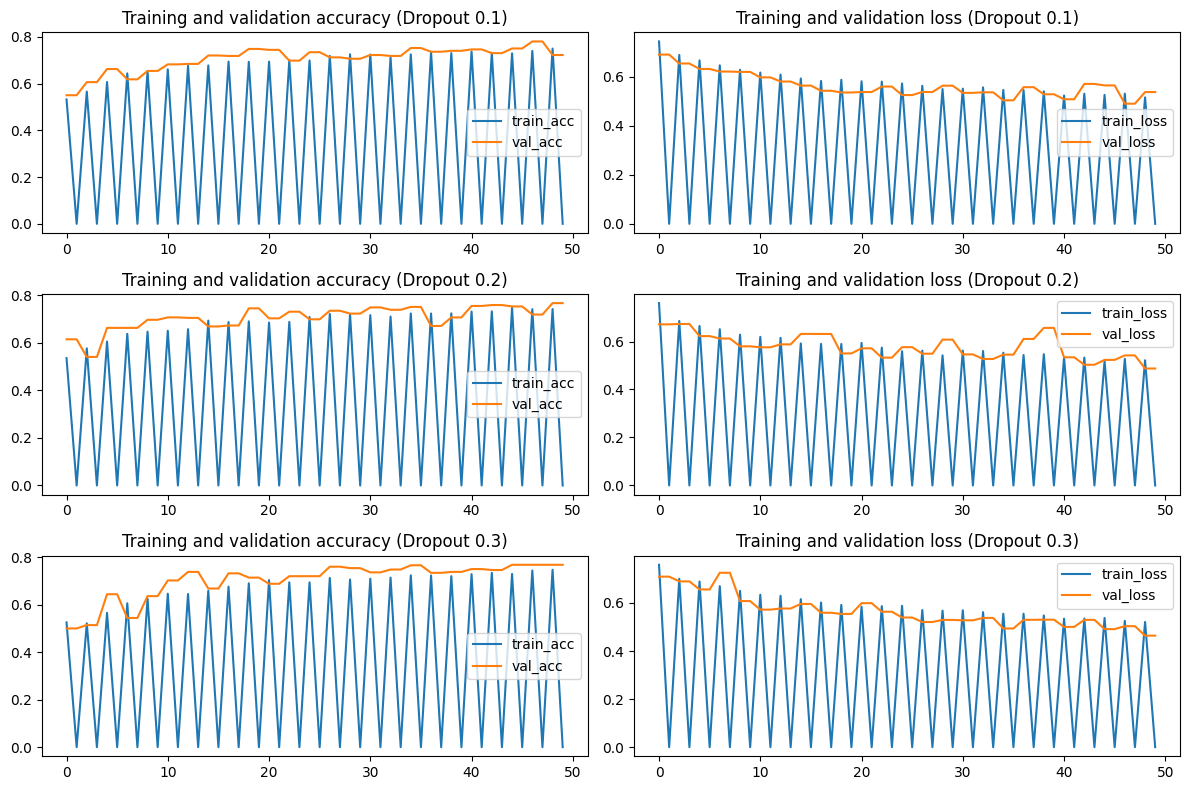

In [16]:
#To see if the results can be improved, a CNN will be created, which are the models that work best for image classification. 
#Different networks will be trained with different dropouts and the model with the best results will be saved in the model folder.

def create_model(dropout_rate):
    img_input = layers.Input(shape=(150, 150, 3))
    x = layers.Conv2D(16, 3, activation='relu')(img_input)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    output = layers.Dense(1, activation='sigmoid')(x)
    model = Model(img_input, output)
    model.compile(loss='binary_crossentropy',
                  optimizer=RMSprop(learning_rate=0.001),
                  metrics=['acc'])
    return model

dropout_rates = [0.1, 0.2, 0.3]
best_val_acc = 0
best_model = None
best_model_name = ''

plt.figure(figsize=(12, 8))
for i, dropout_rate in enumerate(dropout_rates, 1):
    model = create_model(dropout_rate)
    history = model.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=50,
        verbose=1)

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.subplot(3, 2, i * 2 - 1)
    plt.plot(epochs, acc, label='train_acc')
    plt.plot(epochs, val_acc, label='val_acc')
    plt.title(f'Training and validation accuracy (Dropout {dropout_rate})')
    plt.legend()

    plt.subplot(3, 2, i * 2)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title(f'Training and validation loss (Dropout {dropout_rate})')
    plt.legend()

    current_val_acc = max(val_acc)
    print(f'Dropout {dropout_rate} - Validation Accuracy: {current_val_acc}')
    
    if current_val_acc > best_val_acc:
        best_val_acc = current_val_acc
        best_model = model
        best_model_name = f'model_dropout_{dropout_rate}'
print('-'*80)
best_model.save(os.path.join(models_dir, best_model_name + '.h5'))
print(f'Best model: {best_model_name} with Validation Accuracy: {best_val_acc}')
print('-'*80)
print('BEST MODEL TEST: \n')
test_loss, test_acc = best_model.evaluate(test_generator)
print(f'Test accuracy of best model ({best_model_name}): {test_acc}')

y_test = test_generator.classes
y_test_pred = (best_model.predict(test_generator) > 0.5).astype('int32').flatten()
print('Classification report:\n')
print(classification_report(y_test, y_test_pred))

plt.tight_layout()
plt.show()

In [17]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2024-06-24 01:19:02--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolviendo storage.googleapis.com (storage.googleapis.com)... 142.250.200.123, 172.217.17.27, 142.250.201.91, ...
Conectando con storage.googleapis.com (storage.googleapis.com)[142.250.200.123]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 87910968 (84M) [application/x-hdf]
Grabando a: «/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5»

/tmp/inception_v3_w 100%[===================>]  83,84M  7,24MB/s    en 14s     

2024-06-24 01:19:16 (6,02 MB/s) - «/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5» guardado [87910968/87910968]



Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - acc: 0.5161 - loss: 0.7066 - val_acc: 0.4600 - val_loss: 0.7292
Epoch 2/50


2024-06-24 01:21:56.351442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:21:56.487442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.4600 - val_loss: 0.7292
Epoch 3/50


2024-06-24 01:22:01.448691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - acc: 0.4826 - loss: 0.7085 - val_acc: 0.4940 - val_loss: 0.6956
Epoch 4/50


2024-06-24 01:24:21.835674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:24:21.866865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.4940 - val_loss: 0.6956
Epoch 5/50


2024-06-24 01:24:26.732530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - acc: 0.5535 - loss: 0.6823 - val_acc: 0.5580 - val_loss: 0.6770
Epoch 6/50


2024-06-24 01:26:52.293027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:26:52.332643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.5580 - val_loss: 0.6770
Epoch 7/50


2024-06-24 01:26:58.024361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - acc: 0.5599 - loss: 0.6782 - val_acc: 0.6260 - val_loss: 0.6645
Epoch 8/50


2024-06-24 01:29:27.031470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:29:27.072124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.6260 - val_loss: 0.6645
Epoch 9/50


2024-06-24 01:29:32.914491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - acc: 0.6087 - loss: 0.6677 - val_acc: 0.6420 - val_loss: 0.6529
Epoch 10/50


2024-06-24 01:32:02.298420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:32:02.340698: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.6420 - val_loss: 0.6529
Epoch 11/50


2024-06-24 01:32:08.435457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - acc: 0.5907 - loss: 0.6653 - val_acc: 0.6620 - val_loss: 0.6429
Epoch 12/50


2024-06-24 01:34:38.250299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:34:38.287339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.6620 - val_loss: 0.6429
Epoch 13/50


2024-06-24 01:34:43.706383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - acc: 0.6525 - loss: 0.6511 - val_acc: 0.7000 - val_loss: 0.6329
Epoch 14/50


2024-06-24 01:36:58.914187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:36:58.952938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7000 - val_loss: 0.6329
Epoch 15/50


2024-06-24 01:37:04.464907: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - acc: 0.6529 - loss: 0.6433 - val_acc: 0.7160 - val_loss: 0.6235
Epoch 16/50


2024-06-24 01:39:39.916993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:39:39.956191: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7160 - val_loss: 0.6235
Epoch 17/50


2024-06-24 01:39:45.650056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - acc: 0.6553 - loss: 0.6440 - val_acc: 0.7280 - val_loss: 0.6154
Epoch 18/50


2024-06-24 01:42:15.537797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:42:15.576937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7280 - val_loss: 0.6154
Epoch 19/50


2024-06-24 01:42:21.436050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - acc: 0.6748 - loss: 0.6291 - val_acc: 0.7400 - val_loss: 0.6068
Epoch 20/50


2024-06-24 01:44:52.616704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:44:52.655090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7400 - val_loss: 0.6068
Epoch 21/50


2024-06-24 01:44:58.462459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - acc: 0.6890 - loss: 0.6265 - val_acc: 0.7360 - val_loss: 0.5980
Epoch 22/50


2024-06-24 01:47:32.153959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:47:32.192947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7360 - val_loss: 0.5980
Epoch 23/50


2024-06-24 01:47:38.091531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - acc: 0.6685 - loss: 0.6309 - val_acc: 0.7460 - val_loss: 0.5900
Epoch 24/50


2024-06-24 01:50:13.733748: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:50:13.776373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7460 - val_loss: 0.5900
Epoch 25/50


2024-06-24 01:50:20.039982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - acc: 0.6816 - loss: 0.6232 - val_acc: 0.7520 - val_loss: 0.5824
Epoch 26/50


2024-06-24 01:52:56.911144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:52:56.954128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7520 - val_loss: 0.5824
Epoch 27/50


2024-06-24 01:53:03.198382: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - acc: 0.7131 - loss: 0.6187 - val_acc: 0.7680 - val_loss: 0.5738
Epoch 28/50


2024-06-24 01:55:39.565056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:55:39.606965: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7680 - val_loss: 0.5738
Epoch 29/50


2024-06-24 01:55:45.884525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - acc: 0.7280 - loss: 0.5945 - val_acc: 0.7760 - val_loss: 0.5662
Epoch 30/50


2024-06-24 01:58:22.162351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 01:58:22.202099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7760 - val_loss: 0.5662
Epoch 31/50


2024-06-24 01:58:28.087445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - acc: 0.7031 - loss: 0.6033 - val_acc: 0.7760 - val_loss: 0.5592
Epoch 32/50


2024-06-24 02:01:03.840270: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 02:01:03.878942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7760 - val_loss: 0.5592
Epoch 33/50


2024-06-24 02:01:09.812834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - acc: 0.7345 - loss: 0.5965 - val_acc: 0.7900 - val_loss: 0.5517
Epoch 34/50


2024-06-24 02:03:45.870978: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 02:03:45.914339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7900 - val_loss: 0.5517
Epoch 35/50


2024-06-24 02:03:52.214847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - acc: 0.7396 - loss: 0.5894 - val_acc: 0.7800 - val_loss: 0.5452
Epoch 36/50


2024-06-24 02:06:26.929720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 02:06:26.970168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7800 - val_loss: 0.5452
Epoch 37/50


2024-06-24 02:06:32.939563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - acc: 0.7510 - loss: 0.5752 - val_acc: 0.7820 - val_loss: 0.5389
Epoch 38/50


2024-06-24 02:09:08.633661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 02:09:08.674447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7820 - val_loss: 0.5389
Epoch 39/50


2024-06-24 02:09:14.683572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - acc: 0.7510 - loss: 0.5767 - val_acc: 0.7980 - val_loss: 0.5305
Epoch 40/50


2024-06-24 02:11:51.642528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 02:11:51.683763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7980 - val_loss: 0.5305
Epoch 41/50


2024-06-24 02:11:57.664084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - acc: 0.7358 - loss: 0.5732 - val_acc: 0.8040 - val_loss: 0.5228
Epoch 42/50


2024-06-24 02:14:33.588189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 02:14:33.629277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.8040 - val_loss: 0.5228
Epoch 43/50


2024-06-24 02:14:39.741339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - acc: 0.7495 - loss: 0.5689 - val_acc: 0.8000 - val_loss: 0.5173
Epoch 44/50


2024-06-24 02:17:17.563900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 02:17:17.606328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.8000 - val_loss: 0.5173
Epoch 45/50


2024-06-24 02:17:23.946691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - acc: 0.7582 - loss: 0.5672 - val_acc: 0.8120 - val_loss: 0.5112
Epoch 46/50


2024-06-24 02:20:01.537095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 02:20:01.578339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.8120 - val_loss: 0.5112
Epoch 47/50


2024-06-24 02:20:07.626231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - acc: 0.7474 - loss: 0.5705 - val_acc: 0.8260 - val_loss: 0.5048
Epoch 48/50


2024-06-24 02:22:46.926978: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 02:22:46.968613: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.8260 - val_loss: 0.5048
Epoch 49/50


2024-06-24 02:22:53.220126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - acc: 0.7604 - loss: 0.5559 - val_acc: 0.8300 - val_loss: 0.4982
Epoch 50/50


2024-06-24 02:25:32.093568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-24 02:25:32.136410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.8300 - val_loss: 0.4982


2024-06-24 02:25:38.342253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 251ms/step - acc: 0.8439 - loss: 0.5207
--------------------------------------------------------------------------------
BEST MODEL TEST: 

Test accuracy of fine-tuned model: 0.8519999980926514
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 235ms/step


Classification report:

              precision    recall  f1-score   support

           0       0.87      0.83      0.85       250
           1       0.84      0.88      0.86       250

    accuracy                           0.85       500
   macro avg       0.85      0.85      0.85       500
weighted avg       0.85      0.85      0.85       500

--------------------------------------------------------------------------------


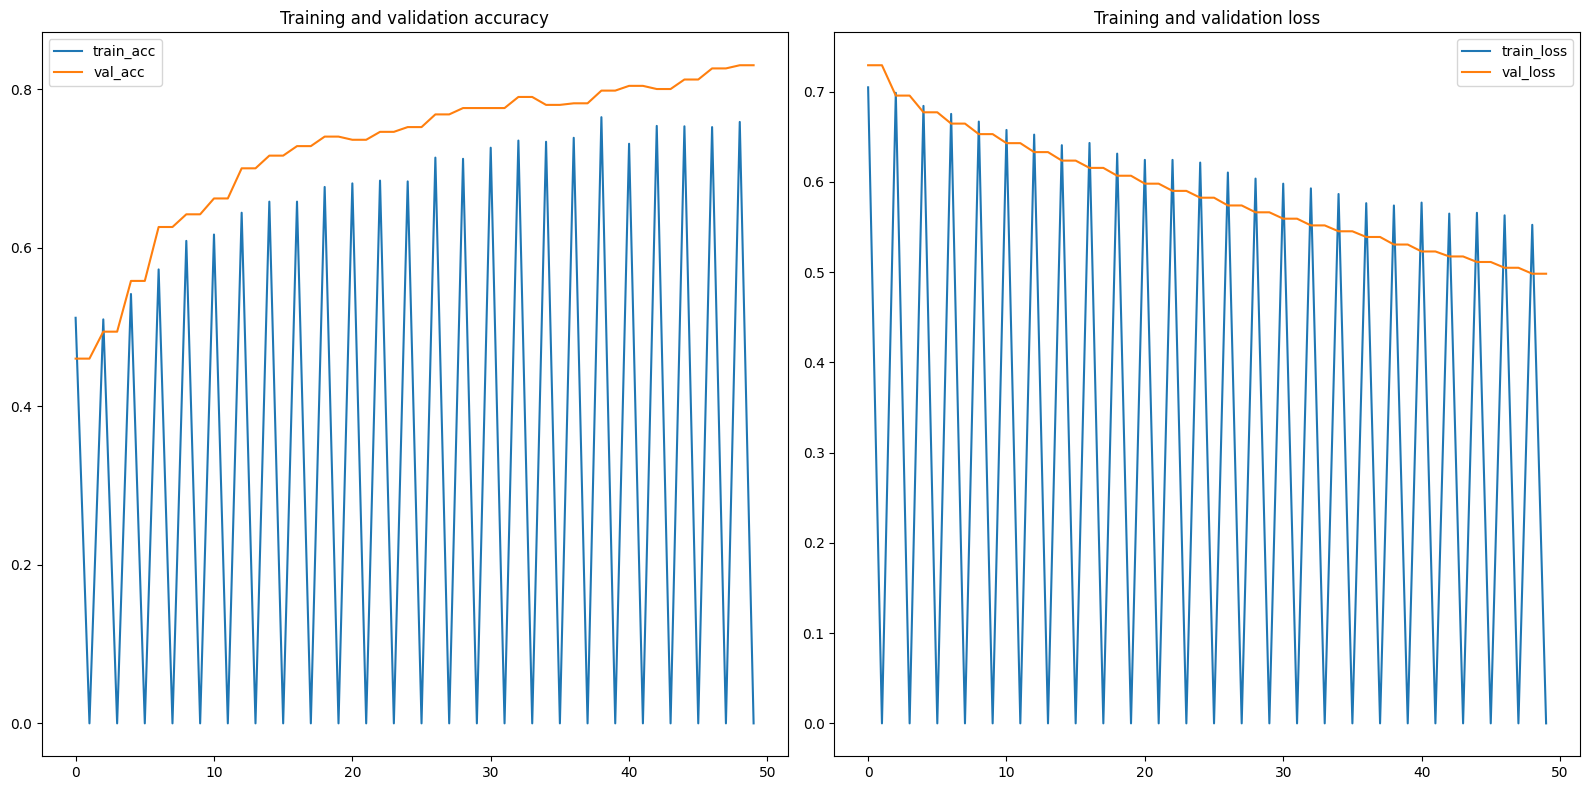

In [18]:
#Fine tuning on a pre-trained model (InceptionV3) with our data set to see if we can increase the accuracy

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

#Unfreeze the specific layers for fine tuning starting from the mixed6 layer
unfreeze = False
for layer in pre_trained_model.layers:
    if unfreeze:
        layer.trainable = True
    if layer.name == 'mixed6':
        unfreeze = True

model.compile(loss='binary_crossentropy',
              optimizer=SGD(learning_rate=0.00001, momentum=0.9),
              metrics=['acc'])

history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=1)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

test_loss, test_acc = model.evaluate(test_generator)
print('-'*80)
print('BEST MODEL TEST: \n')
print(f'Test accuracy of fine-tuned model: {test_acc}')

y_test = test_generator.classes
y_test_pred = (model.predict(test_generator) > 0.5).astype('int32').flatten()
print('Classification report:\n')
print(classification_report(y_test, y_test_pred))
print('-'*80)

model_path = os.path.join(models_dir, 'fine_tuned_inceptionv3.h5')
model.save(model_path)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='train_acc')
plt.plot(epochs, val_acc, label='val_acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Training and validation loss')
plt.legend()

plt.tight_layout()
plt.show()